In [1]:
import numpy as np
import pandas as pd
import pydicom
%matplotlib inline
import matplotlib.pyplot as plt
import keras 
from keras.models import model_from_json
from skimage.transform import resize

Using TensorFlow backend.


In [2]:
def check_dicom(filename):  
    '''
    This function reads in a .dcm file, checks the important fields for our device,
    and returns a numpy array of just the imaging data.
    '''
    print('Load file {} ...'.format(filename))
    dcm = pydicom.dcmread(filename)
    
    body_part = dcm.BodyPartExamined
    position = dcm.PatientPosition
    modality = dcm.Modality
    
    if body_part not in ['CHEST', 'chest', 'Chest']:
        print('Image {} rejected due to body part {}'.format(filename, body_part))
        return None
    if position not in ['PA', 'AP']:
        print('Image {} rejected due to position {}'.format(filename, position))
        return None
    if modality not in ['DX']:
        print('Image {} rejected due to modality {}'.format(filename, modality))
        return None

    return dcm.pixel_array
    
def preprocess_image(img,img_size): 
    '''
    This function takes the numpy array output by check_dicom and 
    runs the appropriate pre-processing needed for our model input
    '''
    img = img / 255
    img = resize(img, img_size)
    proc_img = np.zeros((224,224,3))
    
    return np.resize(proc_img,(1,224,224,3))
def load_model(model_path, weight_path):
    '''
    This function loads in our trained model w/ weights and compiles it
    '''
    json_file = open(model_path, 'r')
    model_json = json_file.read()
    json_file.close()
    model = model_from_json(model_json)
    
    model.load_weights(weight_path)
    print(model)
    
    return model

def predict_image(model, img, thresh): 
    '''
    This function uses our device's threshold parameters to predict whether or not
    the image shows the presence of pneumonia using our trained model
    '''
    pred = model.predict(img)
    prediction = pred > thresh
    
    return prediction[0][0]

def image_distplot(img):
    f = plt.figure()
    f.set_figwidth(10)
    f.add_subplot(1, 2, 1)
    plt.imshow(img)
    f.add_subplot(1, 2, 2)
    plt.hist(img.flatten(), bins=256)
    plt.show()
    
def image_pred(img, filename, pred):
    plt.imshow(img, cmap='gray')
    plt.title('{} /// pred: {}'.format(filename, pred))
    plt.show()
    
def dcm_pred(filename):    
    img = np.array([])
    img = check_dicom(filename)
    
    if img is None:
        return None
        
    img_proc = preprocess_image(img,IMG_SIZE)
    pred = predict_image(my_model,img_proc,thresh)
    return pred


In [4]:
test_dicoms = ['test1.dcm','test2.dcm','test3.dcm','test4.dcm','test5.dcm','test6.dcm']

model_path = "my_model.json"
weight_path = "{}_my_model.best.hdf5".format('xray_class')
IMG_SIZE = (1,224,224,3) # VGG16
img_mean = -1
img_std = -1

my_model = load_model(model_path, weight_path)
thresh = 0.47

Load file test1.dcm ...
Load file test2.dcm ...
Load file test3.dcm ...
Load file test4.dcm ...
Image test4.dcm rejected due to body part RIBCAGE
Load file test5.dcm ...
Image test5.dcm rejected due to modality CT
Load file test6.dcm ...
Image test6.dcm rejected due to position XX


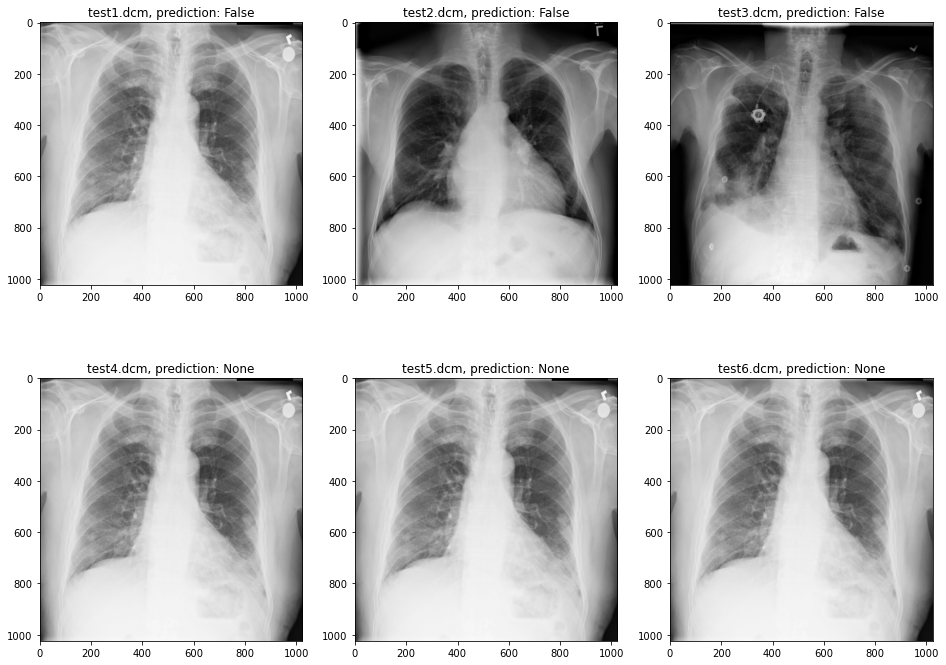

In [5]:
f = plt.figure()
f.set_figwidth(16)
f.set_figheight(12)
    
for i, filename in enumerate(test_dicoms):
    pred = dcm_pred(filename)
    img = pydicom.dcmread(filename).pixel_array        
    s = f.add_subplot(2, 3, i+1)
    s.set_title(f'{filename}, prediction: {pred}')
    plt.imshow(img, cmap='gray')
plt.show()